# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Необходимые условия

* Для оценки качества моделей нужно применить метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Средствами библиотеки LightGBM необходимо построить модели градиентного бустинга.

## Описание данных

**Признаки**

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *Repaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**

*Price* — цена (евро)

## Подготовка данных

### Загрузка библиотек

In [1]:
!pip install lightgbm
!pip install -U scikit-learn

In [2]:
# импорт основных библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm.notebook import tqdm

# импорт спец. модулей
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor



import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 123

### Обзор данных

Загрузим необходимый датасет и посмотрим его основные характеристики:

In [3]:
try:
    data = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen']) 
except:
    data = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
print('Количество пропусков:') 
data.isna().sum()

Количество пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
print('Количество дубликатов:') 
data.duplicated().sum()

Количество дубликатов:


4

### Выводы по обзору данных

* Есть признаки, которые никак не влияют на цену: *DateCrawled*, *RegistrationMonth*, *DateCreated*, *NumberOfPictures*, *PostalCode* и *LastSeen*. От них нам предстоит избавиться.
* В признаках, влияющих на цену, есть пропуски (а именно в столбцах *VehicleType*, *Gearbox*, *Model*, *FuelType* и *Repaired*).
* В столбцах *Price* и *Power* минимальное значение 0, что может свидетельствовать о наличии выбросов.
* В *RegistrationYear* указан минимальный год 1000, что также является ошибочным значением и является выбросом.
* Есть дубликаты, от которых также надо избавиться.
* В названиях признаков надо избавиться от верблюжьего стиля.
* В признаках *Gearbox* и *NotRepaired* значения можно заменить на 1/0.

### Предобработка данных

Сначала преобразуем все названия столбцов и приведём их к змеиному регистру.

In [9]:
#data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
#data.columns

In [10]:
data = data.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())  

data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Избавляемся от явных дубликатов и сразу же проверяем.

In [11]:
data.drop_duplicates(inplace=True)
print('Количество дубликатов:') 
data.duplicated().sum()

Количество дубликатов:


0

Удаляем признаки, которые на прямую не влияют на целевой признак.

In [12]:
data.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'],
           axis=1,
           inplace=True)
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Ещё на этапе обзора данных мы заметили, что в целевой признаке есть нулевые значения. Это явнаые выбросы. Посмотрим, какое же их количество.

In [13]:
data.price.value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64

Удаляем все 0 из столбца *price*.

In [14]:
data = data.query('price > 0')

Посмотрим гистограмму и ящик с усами для нашего целевого признака, чтобы проанализировать наличие дополнительных выбросов в столбце.

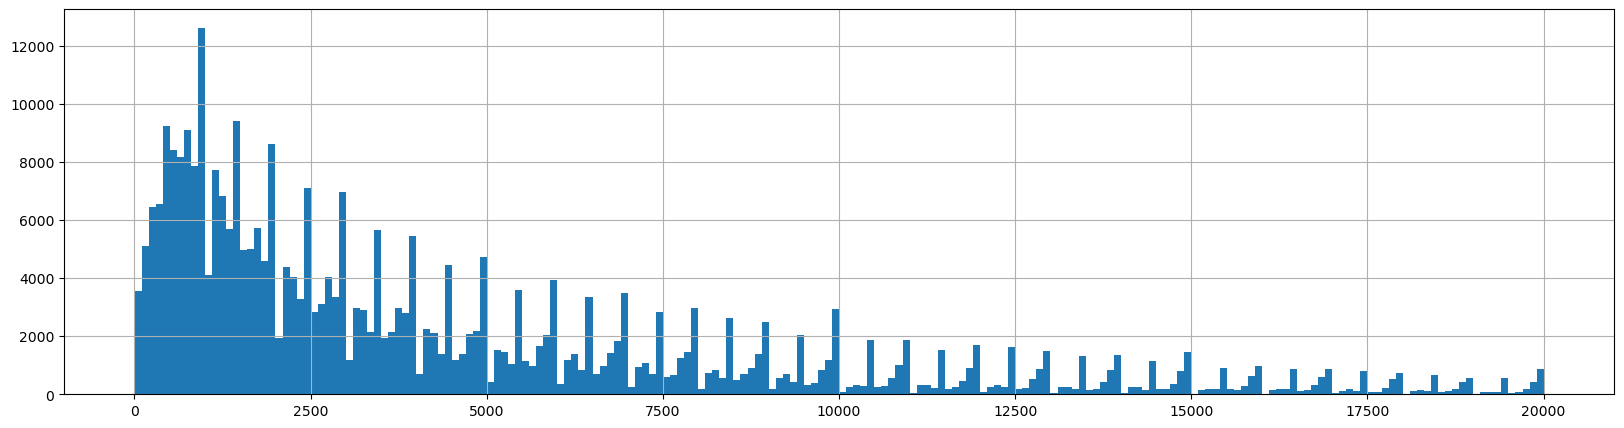

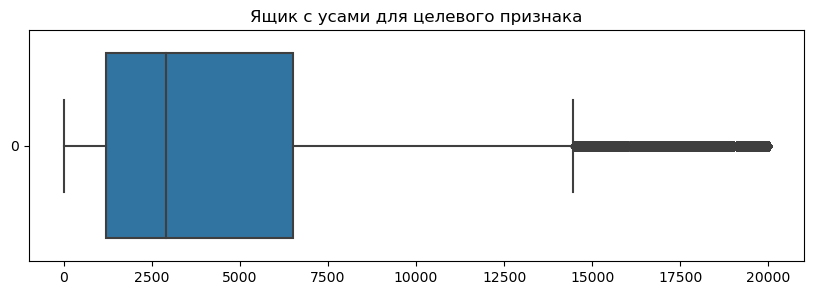

In [15]:
data.price.hist(bins=200, figsize=(20,5))

plt.figure(figsize=(10,3))
sns.boxplot(data=data.price, orient='h')
plt.title('Ящик с усами для целевого признака')
plt.show()

Также для дополнительного понимания посмотрим на квантили, так как по гистограмме заметен длинный хвост, по которому не сразу понятно, что именно является выбросами. По ящику с усами можно сказать, что значения выше 15000 уже можно отбрасывать. 

In [16]:
data.price.quantile([.05, 0.95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

Удаляем данные в соответствии с показателями квантилей.

In [17]:
data = data.query('350 <= price <= 14800')

Далее приступим к столбцу *registration_year* и посмотрим на разброс данных.

In [18]:
reg_year = data.pivot_table(index='registration_year', values='brand', aggfunc='count')
reg_year.columns = ['count']
reg_year

,count
registration_year,
1000,18
1001,1
1039,1
1111,1
1234,2
...,...
8500,1
8888,1
9000,2


Построим гистограмму по столбцу, чтобы примерно понимать распределние данных.

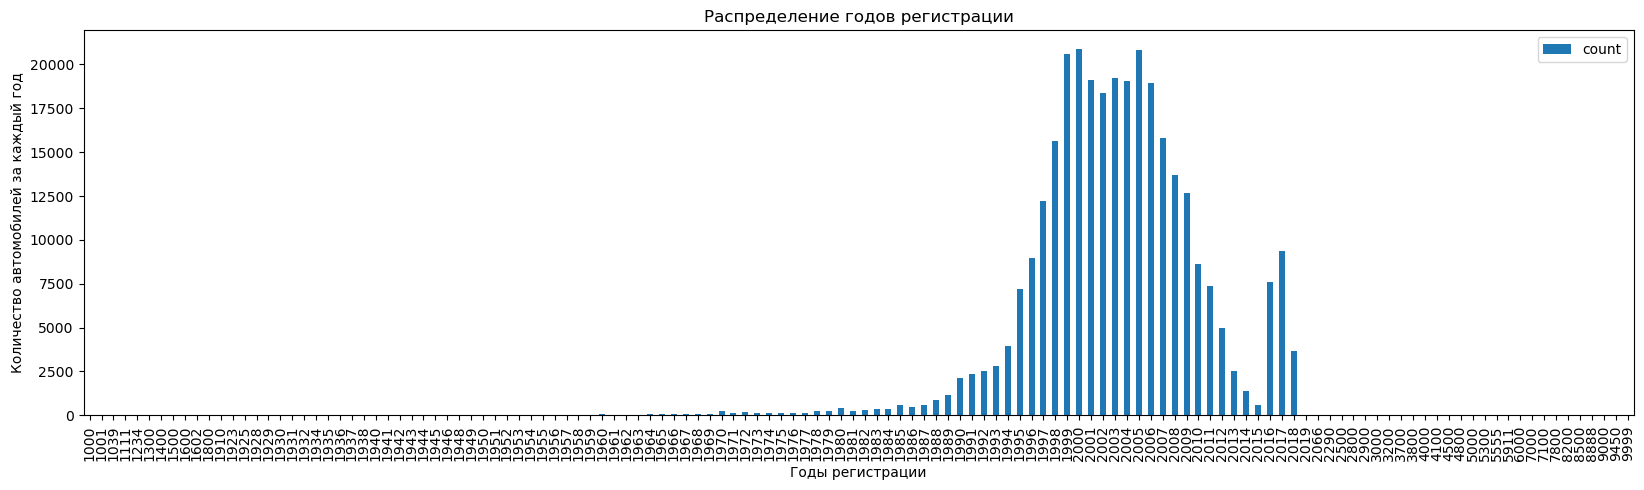

In [19]:
reg_year.plot.bar(figsize = (20,5))
plt.title('Распределение годов регистрации')
plt.xlabel('Годы регистрации')
plt.ylabel('Количество автомобилей за каждый год')
plt.show()

Посмотрим последнюю дату выгрузки данных, чтобы понимать, какие года отбрасывать по верхней планке.

In [20]:
try:
    data_ = pd.read_csv('autos.csv') 
except:
    data_ = pd.read_csv('/datasets/autos.csv')
    
data_.DateCrawled.max()

'2016-04-07 14:36:58'

Удалим данные, где год регистрации раньше 1990 (так как по графику после этого года заметен явный скачок вверх) и позже 2016.

In [21]:
data = data.query('1990 <= registration_year <= 2016')

Далее проверяем на наличие выбросов признак *power*. Построим для него гистограмму.

<Axes: >

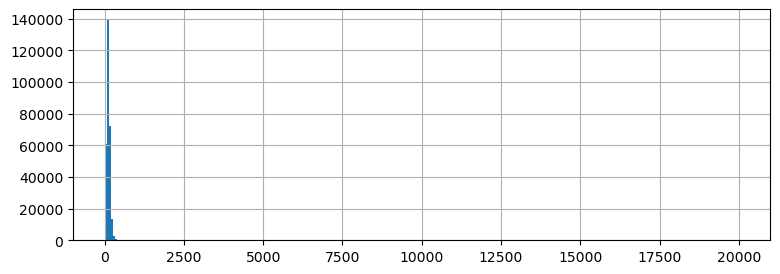

In [22]:
data.power.hist(bins=300, figsize=(9,3))

К сожалению, по гистограмме ничего однозначного сказать невозможно, поэтому попробуем опираться на реальные данные.

При поиске было обнаруженно, что на сегодняшний момент (апрель 2024 г) самым маломощным и более-менее современным автомобилем является *Citroën 2CV* с мощностью *9 л. с.* (его примем за нижнюю границу), а самым мощным удалось установить *Arash AF10 Hybrid* с мощностью равной *2108 л.с.* (его примем за верхнюю границу).

In [23]:
data = data.query('9 <= power <= 2108')

Пропуски в столбце *model* заменяем на значение *unknown* и проверяем.

In [24]:
data.fillna({'model':'unknown'}, inplace=True)
data.model.value_counts()

golf                  21970
other                 16240
3er                   15813
polo                   9651
unknown                9074
                      ...  
amarok                    3
q3                        3
range_rover_evoque        2
gl                        2
rangerover                1
Name: model, Length: 248, dtype: int64

Чтобы избавиться от пропусков в признаке *gearbox* посмотрим на количество данных в каждой из категорий.

In [25]:
data.gearbox.value_counts()

manual    209917
auto       49462
Name: gearbox, dtype: int64

Заменяем пропуски на среднее значение по моделям и проверяем.

In [26]:
data.gearbox = data.gearbox.fillna(data
                                   .groupby('model')['gearbox']
                                   .transform(lambda x: x.value_counts().idxmax())
                                    )

In [27]:
data.gearbox.isna().sum()

0

In [28]:
data.gearbox.value_counts()

manual    213648
auto       50290
Name: gearbox, dtype: int64

Теперь заполним пропуски в параметре *repaired*. Предположим, что владельцы авто могли не заполнять данную информацию, так как автомобиль не был в ремонте, поэтому заменяем пропуски на **no**. Сразу же меняем *yes* на 1, а *no* на 0 для удобства подсчётов в будущем.

In [29]:
data.fillna({'repaired':'no'}, inplace=True)

In [30]:
data.repaired.value_counts()

no     239613
yes     24325
Name: repaired, dtype: int64

Обратим внимание в столбце *fuel_type* - на 'petrol' и 'gasoline', ведь это название одного и того же в разных странах. Поэтому для повышения качества обучения и предсказаний моделей в будуще заменим все на один тип - 'petrol'.

In [31]:
data.loc[data['fuel_type']=='gasoline', 'fuel_type'] = 'petrol'
print('Количество автомобилей с типом топлива "gasoline":', len(data.query('fuel_type=="gasoline"')))
print('Количество автомобилей с типом топлива "petrol"  :', len(data.query('fuel_type=="petrol"')))

Количество автомобилей с типом топлива "gasoline": 0
Количество автомобилей с типом топлива "petrol"  : 245617


Пропуски в столбцах *vehicle_type* и *fuel_type* поменяем на значение unknown, чтобы не потерять их.

In [32]:
data.fillna({'fuel_type':'unknown'}, inplace=True)
data.fuel_type.value_counts()

petrol      245617
unknown      13121
lpg           4474
cng            469
hybrid         154
electric        54
other           49
Name: fuel_type, dtype: int64

In [33]:
data.fillna({'vehicle_type':'unknown'}, inplace=True)
data.vehicle_type.value_counts()

sedan          74258
small          64103
wagon          54488
bus            24117
convertible    15855
coupe          11545
unknown         9055
suv             8464
other           2053
Name: vehicle_type, dtype: int64

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263938 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              263938 non-null  int64 
 1   vehicle_type       263938 non-null  object
 2   registration_year  263938 non-null  int64 
 3   gearbox            263938 non-null  object
 4   power              263938 non-null  int64 
 5   model              263938 non-null  object
 6   kilometer          263938 non-null  int64 
 7   fuel_type          263938 non-null  object
 8   brand              263938 non-null  object
 9   repaired           263938 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.2+ MB


Также посмотрим на корреляцию между целевым признаком и остальными параметрами. Для начала загрузим и посмотрим на матрицу корреляции по Пирсону:

In [35]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,registration_year,power,kilometer
price,1.000000,0.598962,0.371462,-0.343937
registration_year,0.598962,1.000000,0.053404,-0.375806
power,0.371462,0.053404,1.000000,0.129798
kilometer,-0.343937,-0.375806,0.129798,1.000000


Построили таблицу корреляции признаков - можем отметить, что больше всего целевой признак зависит от **registrationg_year** (0.599) и **power** (0.371). В остальных случаях, даже между собой, признаки практически никак не коррелируют.

Теперь проведём тестирование мультколлинеарности целевого признака и остальных столбцов с помощью функции *variance_inflation_factor()*. Если какой-то из признаков будет иметь показатель больше 5, то это может свидетельствовать о серьёзной корреляции между признаками.

In [36]:
y, X = dmatrices('price ~ registration_year+power+kilometer', data=data, return_type='dataframe')

In [37]:
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns

In [38]:
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df

,variable,VIF
0,Intercept,169648.061046
1,registration_year,1.179037
2,power,1.029872
3,kilometer,1.195821


Как мы можем заметить, каждое из значений VIF для признаков в данных стремится к 1, значит мультиколлинеарность не является проблемой.

### Выводы по предобработке данных

* Привели все названия столбцов к змеиному регистру;
* Избавились от явных дубликатов и неинформативных признаков;
* Почистили от выбросов признаки **price**, **registrationg_year** и **power**;
* Заполнили пропуски в столбцах: 
    * **model** - заменили на значение *uknown*, 
    * **gearbox** - отсортировали и заполнили по признаку *model*,
    * **repaired** - по смысле поменяли на *no*,
    * **vehicle_type** - заменили на значение *uknown*,
    * **fuel_type** - заменили на значение *uknown*;
* Построили таблицу корреляции признаков и проверили мультиколлинеарность с помощью функции VIF - можем отметить, что больше всего целевой признак зависит от **registrationg_year** (0.599) и **power** (0.371). В остальных случаях, даже между собой, признаки практически никак не коррелируют. Проверка на показатель VIF также прошла успешно.

## Обучение моделей

Сначала разделим данные на основные признаки и целевой.

In [39]:
features_orig = data.drop('price', axis=1)
target = data.price

Далее разделим данные на тренирововчную выборку, валидационную и тестовую в соотношении 60/20/20.

In [40]:
features_train, features_other, target_train, target_other = train_test_split(features_orig,
                                                                            target, 
                                                                            test_size=.4,
                                                                            random_state=123)

In [41]:
features_valid, features_test, target_valid, target_test = train_test_split(features_other,
                                                                            target_other, 
                                                                            test_size=.5,
                                                                            random_state=123)

In [42]:
features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
148539,small,2002,auto,41,unknown,150000,petrol,smart,no
307738,coupe,2007,auto,250,tt,125000,petrol,audi,yes
248940,wagon,2002,manual,101,fabia,150000,petrol,skoda,no
207568,sedan,1996,manual,60,golf,150000,petrol,volkswagen,no
93951,sedan,2003,manual,142,3er,150000,petrol,bmw,no


Закодируем категориальные признаки двумя методами - OHE и OE, так как для разных видов моделей потребуются разные типа кодировок. Сразу же отмасштабируем признаки.

In [43]:
category = features_train.select_dtypes(include='object').columns.to_list()

# One Hot Encoding

features_train_ohe = features_train.copy()
features_valid_ohe = features_valid.copy()
features_test_ohe = features_test.copy()

OHE_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
OHE_encoder.fit(features_train_ohe[category])
features_train_ohe[
    OHE_encoder.get_feature_names_out()
] = OHE_encoder.transform(features_train_ohe[category])
features_train_ohe = features_train_ohe.drop(category, axis=1)

features_valid_ohe[
    OHE_encoder.get_feature_names_out()
] = OHE_encoder.transform(features_valid_ohe[category])

features_valid_ohe = features_valid_ohe.drop(category, axis=1)

features_test_ohe[
    OHE_encoder.get_feature_names_out()
] = OHE_encoder.transform(features_test_ohe[category])

features_test_ohe = features_test_ohe.drop(category, axis=1)




# Ordinal Encoding
OE_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=(-1)) # UPD
OE_encoder.fit(features_train[category])
for features in [features_train, features_valid, features_test]:
    features[category] = OE_encoder.transform(features[category])

In [44]:
# масштабирование признаков
numeric = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
for features in [features_train, features_valid, features_test]:
    features[numeric] = scaler.transform(features[numeric])

Выведем размерность каждой из выборок, чтобы убедиться в соразмерности количества строк в каждой из них.

In [45]:
for i in [features_train_ohe, features_valid_ohe, features_test_ohe]:
    print(i.shape)    
    
print()
    
for i in [features_train, features_valid, features_test]:
    print(i.shape)

(158362, 305)
(52788, 305)
(52788, 305)

(158362, 9)
(52788, 9)
(52788, 9)


Видим, что выборки везде одинаковы по размерности строк. Далее переходим к обучению моделей и подбору гиперпараметров.

### LinearRegression

#### Данные с кодированием OneHotEncoder

In [46]:
%%time

model_lr = LinearRegression()

cv_rmse_lr = (cross_val_score(model_lr, 
                             features_train_ohe, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
cv_rmse_lr

CPU times: total: 38.9 s
Wall time: 17.2 s


1953.421741305466

### RandomForestRegressor

#### Данные с кодированием OrdinalEncoder

In [47]:
%%time

rmse_min = 2500

for est in tqdm(range(10, 41, 10)):
    for depth in range(5, 16):
        model_rf = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=123)
        model_rf.fit(features_train, target_train)
        prediction_valid = model_rf.predict(features_valid)
        rmse = np.sqrt(mean_squared_error(target_valid, prediction_valid))
        if rmse_min >= rmse:
            rmse_min = rmse 
            best_dep = depth
            best_est = est
            best_RF = model_rf
            
print('Минимальная погрешность:', rmse_min, 'при кол-ве деревьев:', best_est, 'и их глубине:', best_dep)

  0%|          | 0/4 [00:00<?, ?it/s]

Минимальная погрешность: 1327.2492102043514 при кол-ве деревьев: 40 и их глубине: 15
CPU times: total: 8min 23s
Wall time: 8min 54s


### LightGBMRegressor

#### Данные с кодированием OrdinalEncoder

In [48]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[123]}]


clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 126689, number of used features: 9
[LightGBM] [Info] Start training from score 4273.231109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 126689, number of used features: 9
[LightGBM] [Info] Start training from score 4270.762710
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 126689, number of used features: 9
[LightGBM] [Info] Start training from score 4270.762710
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 126690, number of used features: 9
[LightGBM] [Info] Start training from score 4266.262341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 126690, number of used features: 9
[LightGBM] [Info] Start training from score 4266.262341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 126690, number of used features: 9
[LightGBM] [Info] Start training from score 4276.635133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

1273.3309722989777

In [49]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=100, random_state=123)
model_lgbmr.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 158362, number of used features: 9
[LightGBM] [Info] Start training from score 4272.233105
CPU times: total: 2.86 s
Wall time: 1.12 s


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=123)

In [50]:
%%time

prediction_valid = model_lgbmr.predict(features_valid)

CPU times: total: 438 ms
Wall time: 177 ms


In [51]:
rsme_lgbmr_oe = mean_squared_error(target_valid, prediction_valid) ** .5
rsme_lgbmr_oe

1274.4640699022036

### Выводы по обучению моделей

* Обучили 3 модели - LinearRegression, RandomForestRegressor и LGBMRegressor - со сменой гиперпараметров.
* Далее посмотрим результаты предсказаний каждой из моделей с лучшими гиперпараметрами на тестовой выборке, составим сравнительную таблицу с рейтингом и выберем наилучшую модель по финальному тестированию на независимых, скрытых изначально данных.

## Анализ моделей

### LinearRegression

In [52]:
%%time

model_lr.fit(features_train_ohe, target_train)

CPU times: total: 9.27 s
Wall time: 4.1 s


LinearRegression()

In [53]:
%%time

prediction_lr = model_lr.predict(features_test_ohe)
final_RMSE_LR = mean_squared_error(target_test, prediction_lr) ** 0.5
final_RMSE_LR

CPU times: total: 344 ms
Wall time: 373 ms


1934.3575633650917

### RandomForestRegressor

In [54]:
%%time

model_rf.fit(features_train, target_train)

CPU times: total: 25.3 s
Wall time: 26.6 s


RandomForestRegressor(max_depth=15, n_estimators=40, random_state=123)

In [55]:
%%time

prediction_rf = model_rf.predict(features_test)
final_RMSE_RF = mean_squared_error(target_test, prediction_rf) ** 0.5
final_RMSE_RF

CPU times: total: 844 ms
Wall time: 935 ms


1332.0633449780328

### LightGBMRegressor

In [56]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=100, random_state=123)
model_lgbmr.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 158362, number of used features: 9
[LightGBM] [Info] Start training from score 4272.233105
CPU times: total: 3.44 s
Wall time: 1.46 s


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=123)

In [57]:
%%time

prediction_lgbmr = model_lgbmr.predict(features_test)
final_RMSE_LGBMR = mean_squared_error(target_test, prediction_rf) ** 0.5
final_RMSE_LGBMR

CPU times: total: 609 ms
Wall time: 192 ms


1332.0633449780328

Соберем сводную таблицу с показателями всех моделей и сравним их между собой с помощью рейтинга - для этого каждый из показателей умножим на 1/3 (так как все 3 показателя - метрика RMSE, время обучения и предсказания - для нас в приоритете). Сложим вместе резульаты по каждой модели, чтобы получился коэффициент, по которому можно будет делать окончательные выводы.

In [58]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'LGBMRegressor'
        ]

data = {'RMSE':[final_RMSE_LR,
                final_RMSE_RF,
                final_RMSE_LGBMR],
        
        'Время обучения модели':[7.12,
                                 14.5,
                                 1.17],
        
        'Время предсказания модели':[0.0781,
                                     0.389,
                                     0.234]
       }

models = pd.DataFrame(data=data, index=index)

#ввожу столбец Рейтинг с весами:
models['Рейтинг'] = (models['RMSE'] * .34 \
                       + models['Время обучения модели'] * .33 \
                       + models['Время предсказания модели'] * .33)

models.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
LGBMRegressor,1332.063345,1.17,0.2340,453.364857
RandomForestRegressor,1332.063345,14.50,0.3890,457.814907
LinearRegression,1934.357563,7.12,0.0781,660.056945


Лучшей моделью по всем трём параметрам является ***LGBMRegressorE***. Наихудший результат показала модель ***LinearRegression***.

## Общий вывод

Данный проект мы выполнили в несколько этапов:
* загрузили и провели обработку данных - почистили данные от выбросов и дубликатов, по возомжности максимально заполнили пропуски;
* закодировали данные двумя методиками - OHE и OE, с помощью них проверили и сравнили 3 разные модели - LinearRegression, RandomForestRegressor и LGBMRegressor;
* выбрали лучшую модель по 3 показателям - RMSE, время обучения и время предскзания.

По итогам проделанной работы можем сделать следующие выводы:
* моделью с самыми низким показателемя RMSE оказались ***LGBMRegressor*** и ***RandomForestRegressor***;
* моделью с самым быстрым временем обучения вышла ***LGBMRegressor***, а моделью с самым быстрым временем предсказания является ***LinearRegression***;
* лучшей моделью по всем трём параметрам, если считать их одинаково важными для принятия решения, является ***LGBMRegressor***, поэтому можем считать её наиболее подходящей для заказчика.